### ARIMA-TimeSeries Analysis of Tractor Sales

In this case study example, we will learn about time series analysis for a manufacturing operation. Time series analysis and modeling have many business and social applications. It is extensively used to forecast company sales, product demand, stock market trends, agricultural production etc.

The fundamental idea for time series analysis is to decompose the original time series (sales, stock market trends, etc.) into several independent components. Typically, business time series are divided into the following four components:

- Trend – overall direction of the series i.e. upwards, downwards etc.
- Seasonality – monthly or quarterly patterns
- Cycle – long-term business cycles, they usually come after 5 or 7 years
- Irregular remainder – random noise left after extraction of all the components

Interference of these components produces the final series.

### Problem Definition
PowerHorse, a tractor and farm equipment manufacturing company, was established a few years after World War II. The company has shown a consistent growth in its revenue from tractor sales since its inception. However, over the years the company has struggled to keep it’s inventory and production cost down because of variability in sales and tractor demand. The management at PowerHorse is under enormous pressure from the shareholders and board to reduce the production cost. Additionally, they are also interested in understanding the impact of their marketing and farmer connect efforts towards overall sales. In the same effort, they have hired us as a data science and predictive analytics consultant.

We will develop an model to forecast sale / demand of tractor for next 3 years. Additionally, We will also investigate the impact of marketing program on sales 

As a part of this project, one of the production units we are analysing is based in South East Asia. This unit is completely independent and caters to neighbouring geographies. This unit is just a decade and a half old. In 2014 , they captured 11% of the market share, a 14% increase from the previous year. However, being a new unit they have very little bargaining power with their suppliers to implement Just-in-Time (JiT) manufacturing principles that have worked really well in PowerHorse’s base location. Hence, they want to be on top of their production planning to maintain healthy business margins. Monthly sales forecast is the first step we have suggested to this unit towards effective inventory management.

The MIS team shared the month on month (MoM) sales figures (number of tractors sold) for the last 12 years in the tractor-sales.csv file.

### Univariate Time Series

In [1]:
import warnings
import itertools

import pandas as pd
import numpy as np

#import statsmodels.api as sm
import statsmodels.tsa.api as smt
#import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

#### Step 1: Visualize Tractor Sales data as time series

In [2]:
sales_data = pd.read_csv("Tractor-Sales.csv")
sales_data.head(5)


,Month-Year,Number of Tractor Sold
0,Jan-03,141
1,Feb-03,157
2,Mar-03,185
3,Apr-03,199
4,May-03,203


In [3]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Month-Year              144 non-null    object
 1   Number of Tractor Sold  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [4]:
# since the complete date was not mentioned, we assume that it was the first of every month
dates = pd.date_range(start='2003-01-01', freq='MS', periods=len(sales_data))

In [5]:
?pd.date_range

In [6]:
import calendar
sales_data['Month'] = dates.month
sales_data['Month'] = sales_data['Month'].apply(lambda x: calendar.month_abbr[x])
sales_data['Year'] = dates.year

In [7]:
sales_data.head()

,Month-Year,Number of Tractor Sold,Month,Year
0,Jan-03,141,Jan,2003
1,Feb-03,157,Feb,2003
2,Mar-03,185,Mar,2003
3,Apr-03,199,Apr,2003
4,May-03,203,May,2003


In [8]:
sales_data.drop(['Month-Year'], axis=1, inplace=True)
sales_data.rename(columns={'Number of Tractor Sold':'Tractor-Sales'}, inplace=True)
sales_data = sales_data[['Month', 'Year', 'Tractor-Sales']]

In [9]:
sales_data.head()

,Month,Year,Tractor-Sales
0,Jan,2003,141
1,Feb,2003,157
2,Mar,2003,185
3,Apr,2003,199
4,May,2003,203


In [10]:
# set the dates as the index of the dataframe, so that it can be treated as a time-series dataframe
sales_data.set_index(dates, inplace=True)

In [11]:
# check out first 5 samples of the data
sales_data.head(5)

,Month,Year,Tractor-Sales
2003-01-01,Jan,2003,141
2003-02-01,Feb,2003,157
2003-03-01,Mar,2003,185
2003-04-01,Apr,2003,199
2003-05-01,May,2003,203


In [12]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 2003-01-01 to 2014-12-01
Freq: MS
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Month          144 non-null    object
 1   Year           144 non-null    int64 
 2   Tractor-Sales  144 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 4.5+ KB


In [13]:
# extract out the time-series
sales_ts = sales_data['Tractor-Sales']

In [14]:
sales_ts.head()

2003-01-01    141
2003-02-01    157
2003-03-01    185
2003-04-01    199
2003-05-01    203
Freq: MS, Name: Tractor-Sales, dtype: int64

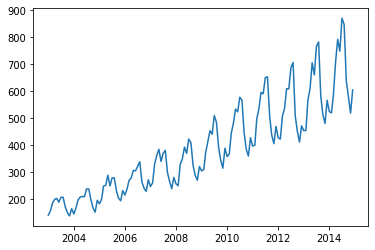

In [15]:
plt.plot(sales_ts)

Text(0, 0.5, 'Tractor Sales')

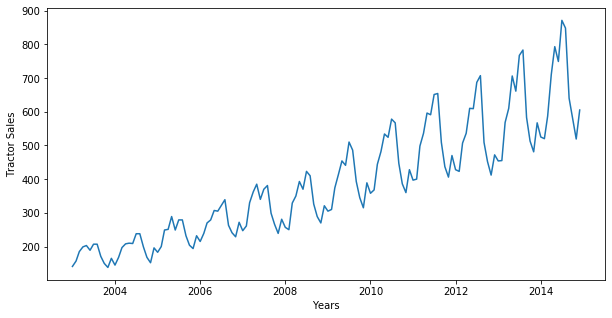

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(sales_ts)
plt.xlabel('Years')
plt.ylabel('Tractor Sales')

In [17]:
sales_ts.rolling(window=3).mean()

2003-01-01           NaN
2003-02-01           NaN
2003-03-01    161.000000
2003-04-01    180.333333
2003-05-01    195.666667
                 ...    
2014-08-01    822.666667
2014-09-01    786.333333
2014-10-01    689.666667
2014-11-01    580.000000
2014-12-01    568.333333
Freq: MS, Name: Tractor-Sales, Length: 144, dtype: float64

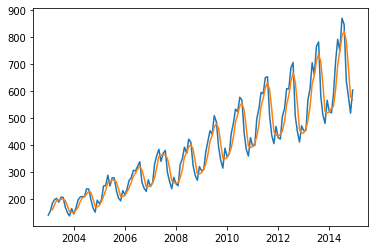

In [18]:
plt.plot(sales_ts.index, sales_ts)
plt.plot(sales_ts.index, sales_ts.rolling(window=3).mean())

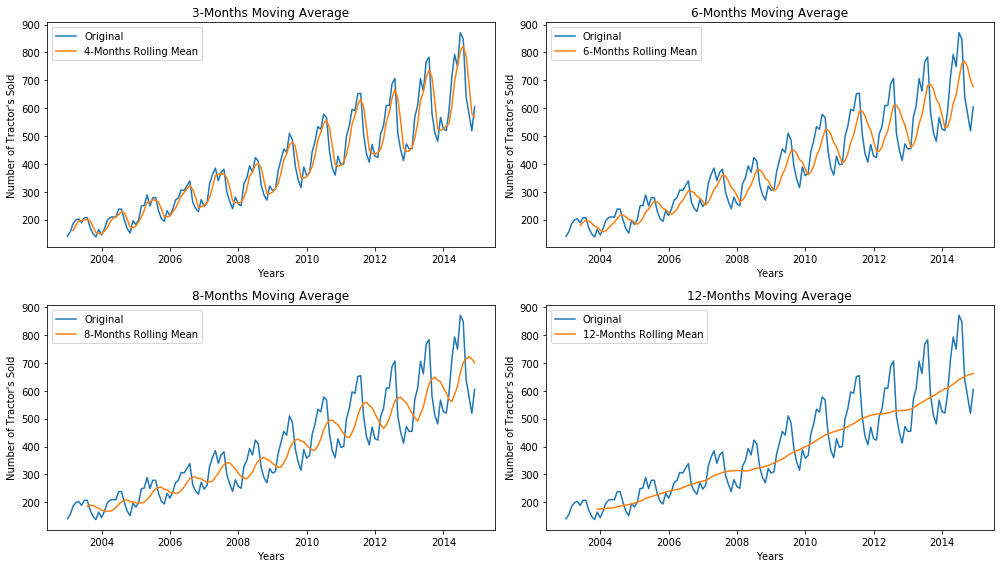

In [19]:
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)

axes[0][0].plot(sales_ts.index, sales_ts, label='Original')
axes[0][0].plot(sales_ts.index, sales_ts.rolling(window=3).mean(), label='4-Months Rolling Mean')
axes[0][0].set_xlabel("Years")
axes[0][0].set_ylabel("Number of Tractor's Sold")
axes[0][0].set_title("3-Months Moving Average")
axes[0][0].legend(loc='best')

axes[0][1].plot(sales_ts.index, sales_ts, label='Original')
axes[0][1].plot(sales_ts.index, sales_ts.rolling(window=6).mean(), label='6-Months Rolling Mean')
axes[0][1].set_xlabel("Years")
axes[0][1].set_ylabel("Number of Tractor's Sold")
axes[0][1].set_title("6-Months Moving Average")
axes[0][1].legend(loc='best')

axes[1][0].plot(sales_ts.index, sales_ts, label='Original')
axes[1][0].plot(sales_ts.index, sales_ts.rolling(window=8).mean(), label='8-Months Rolling Mean')
axes[1][0].set_xlabel("Years")
axes[1][0].set_ylabel("Number of Tractor's Sold")
axes[1][0].set_title("8-Months Moving Average")
axes[1][0].legend(loc='best')

axes[1][1].plot(sales_ts.index, sales_ts, label='Original')
axes[1][1].plot(sales_ts.index, sales_ts.rolling(window=12).mean(), label='12-Months Rolling Mean')
axes[1][1].set_xlabel("Years")
axes[1][1].set_ylabel("Number of Tractor's Sold")
axes[1][1].set_title("12-Months Moving Average")
axes[1][1].legend(loc='best')

plt.tight_layout()
plt.show()

As we could see in the above plots, 12-month moving average could produce a wrinkle free curve as desired. This on some level is expected since we are using month-wise data for our analysis and there is expected monthly-seasonal effect in our data.

Let's plot the rolling mean and standard deviation on window of 12 months.

#### Step 1.2: Seasonality – Time Series Decomposition

The first thing to do is to see how number of tractors sold vary on a month on month basis. We will plot a stacked annual plot to observe seasonality in our data.

In [20]:
sales_data.to_csv(r"C:\Users\Admin\Desktop\Training\PGAA001\TS\Sales.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Admin\\Desktop\\Training\\PGAA001\\TS\\Sales.csv'

In [21]:
monthly_sales_data = pd.pivot_table(sales_data, values = "Tractor-Sales", columns = "Year", index = "Month")
monthly_sales_data = monthly_sales_data.reindex(index = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
monthly_sales_data

Year,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Month,,,,,,,,,,,,
Jan,141,145,183,215,247,257,305,358,397,428,454,525
Feb,157,168,200,239,261,250,310,368,400,423,455,520
Mar,185,197,249,270,330,329,374,444,498,507,568,587
Apr,199,208,251,279,362,350,414,482,536,536,610,710
May,203,210,289,307,385,393,454,534,596,610,706,793
Jun,189,209,249,305,340,370,441,524,591,609,661,749
Jul,207,238,279,322,370,423,510,578,651,687,767,871
Aug,207,238,279,339,381,410,486,567,654,707,783,848
Sep,171,199,232,263,299,326,393,447,509,509,583,640


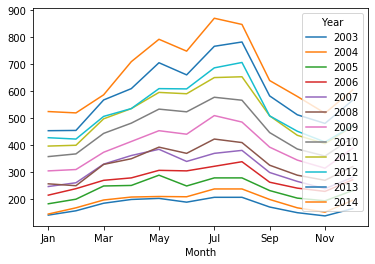

In [22]:
monthly_sales_data.plot()

In [23]:
yearly_sales_data = pd.pivot_table(sales_data, values = "Tractor-Sales", columns = "Month", index = "Year")
yearly_sales_data = yearly_sales_data[['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
yearly_sales_data

Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2003,141,157,185,199,203,189,207,207,171,150,138,165
2004,145,168,197,208,210,209,238,238,199,168,152,196
2005,183,200,249,251,289,249,279,279,232,204,194,232
2006,215,239,270,279,307,305,322,339,263,241,229,272
2007,247,261,330,362,385,340,370,381,299,266,239,281
2008,257,250,329,350,393,370,423,410,326,289,270,321
2009,305,310,374,414,454,441,510,486,393,345,315,389
2010,358,368,444,482,534,524,578,567,447,386,360,428
2011,397,400,498,536,596,591,651,654,509,437,406,470


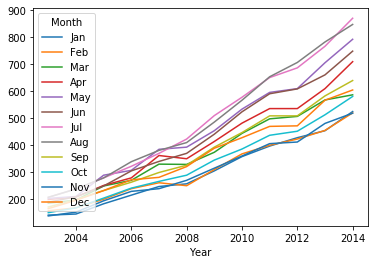

In [24]:
yearly_sales_data.plot()

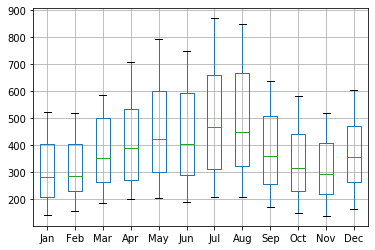

In [25]:
yearly_sales_data.boxplot()

#### Important Inferences

The tractor sales have been increasing without fail every year.

July and August are the peak months for tractor sales and the variance and the mean value in July and August are also much higher than any of the other months.

We can see a seasonal cycle of 12 months where the mean value of each month starts with a increasing trend in the beginning of the year and drops down towards the end of the year. We can see a seasonal effect with a cycle of 12 months.


#### Step 1.3: Irregular Remainder – Time Series Decomposition
To decipher underlying patterns in tractor sales, we build a multiplicative time series decomposition model with the following equation:

- Yt=Trendt×Seasonalityt×Remaindert
 
Instead of multiplicative model we could have chosen additive model as well. In that case the equaltion would have been:

- Yt=Trendt+Seasonalityt+Remaindert
 
However, it would have made very little difference in terms of conclusion we will draw from this time series decomposition exercise. Additionally, we are also aware that plain vanilla decomposition models like these are rarely used for forecasting. Their primary purpose is to understand underlying patterns in temporal data to use in more sophisticated analysis like Holt-Winters seasonal method or ARIMA.

In [26]:
import statsmodels as sm

In [27]:
decomposition = sm.tsa.seasonal.seasonal_decompose(sales_ts, model='multiplicative',two_sided=False, extrapolate_trend=4)

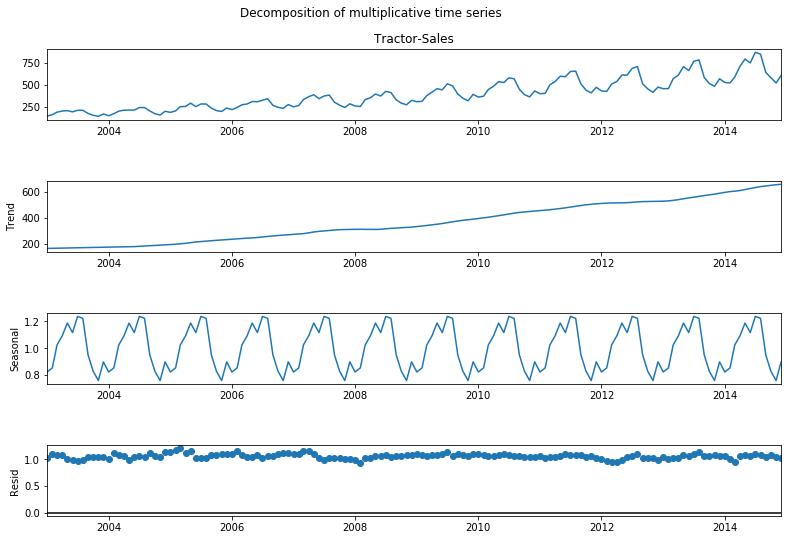

In [28]:

fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

In [29]:
decomp_output = pd.DataFrame(pd.concat([decomposition.observed, decomposition.trend, decomposition.seasonal, decomposition.resid], axis=1))

In [30]:
decomp_output.columns = ['observed', 'Trend', 'Seasonal', 'Irregular']

In [31]:
decomp_output.head()

,observed,Trend,Seasonal,Irregular
2003-01-01,141.0,166.408333,0.823508,1.028907
2003-02-01,157.0,167.216667,0.853891,1.099557
2003-03-01,185.0,168.025000,1.024830,1.074350
2003-04-01,199.0,168.833333,1.092962,1.078424
2003-05-01,203.0,169.641667,1.187805,1.007438


In [32]:
decomp_output['TSI'] = decomp_output.Trend*decomp_output.Seasonal*decomp_output.Irregular

In [33]:
decomp_output

,observed,Trend,Seasonal,Irregular,TSI
2003-01-01,141.0,166.408333,0.823508,1.028907,141.0
2003-02-01,157.0,167.216667,0.853891,1.099557,157.0
2003-03-01,185.0,168.025000,1.024830,1.074350,185.0
2003-04-01,199.0,168.833333,1.092962,1.078424,199.0
2003-05-01,203.0,169.641667,1.187805,1.007438,203.0
...,...,...,...,...,...
2014-08-01,848.0,642.875000,1.222687,1.078833,848.0
2014-09-01,640.0,647.958333,0.950868,1.038754,640.0
2014-10-01,581.0,653.166667,0.829943,1.071776,581.0
2014-11-01,519.0,657.583333,0.760143,1.038297,519.0


### Forecasting using decomposition with the help of STLDECOMPOSE PACKAGE

In [34]:
#pip install stldecompose
#import stldecompose as stl
# the main library has a small set of functionality
from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive,
                                         drift, 
                                         mean, 
                                         seasonal_naive)

ImportError: cannot import name '_maybe_get_pandas_wrapper_freq' from 'statsmodels.tsa.filters._utils' (C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\filters\_utils.py)

#### Decomposition

In [35]:
decompose?

Object `decompose` not found.


One of the primary pieces of functionality is the STL decomposition. The associated method requires the observation frame, and the primary (largest) period of seasonality. This period is specified in terms of index positions, and so care is needed for the user to correctly specify the periodicity in terms of their observations.

For example, with daily observations and large annual cycles, period=365. For hourly observations with large daily cycles, period=24. Some inspection, and trial and error may be helpful.

In [36]:
decomp = decompose(sales_ts, period=12)

NameError: name 'decompose' is not defined

In [37]:
decomp.plot();

NameError: name 'decomp' is not defined

#### Forecast
While the STL decomposition is interesting on its own, STLDecompose also provides some relatively naive capabilities for using the decomposition to forecast based on our observations.

We'll use the same data set, but pretend that we only had the first two third of observations. Then we can compare our forecast to the real observation data.

The forecast() method requires the following arguments:

the previously fit DecomposeResult
the number of steps forward for which we'd like the forecast
the specific forecasting function to be applied to the decomposition
There are a handful of predefined functions that can be imported from the stldecompose.forecast_funcs module.

In [ ]:
fcast = forecast(decomp, steps=36, fc_func=drift, seasonal=True)
fcast 

In [ ]:
plt.plot(sales_ts, '--', label='obs')
plt.plot(decomp.trend, ':', label='decomp.trend')
plt.plot(fcast, '-', label=fcast.columns[0])

plt.legend();

### ETS Models (Exponential Smoothening Models)

### Single Exponential Smoothing
Single Exponential Smoothing or simple smoothing can be implemented in Python via the SimpleExpSmoothing Statsmodels class.

First, an instance of the SimpleExpSmoothing class must be instantiated and passed the training data. The fit() function is then called providing the fit configuration, specifically the alpha value called smoothing_level. If this is not provided or set to None, the model will automatically optimize the value.

This fit() function returns an instance of the HoltWintersResults class that contains the learned coefficients. The forecast() or the predict() function on the result object can be called to make a forecast.

In [38]:
### single exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# our guessed parameters
alpha = 0.4
beta = 0.2
gamma = 0.01

# initialise model
ets_model = ExponentialSmoothing(sales_ts, trend='mul', seasonal='mul', seasonal_periods=12)
ets_fit = ets_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)

In [39]:
# forecast p months ahead
p_ahead = 36
yh = ets_fit.forecast(p_ahead)

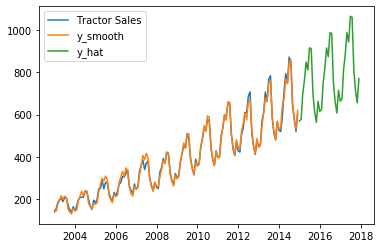

In [40]:
# plot the y, y_smoothed and y_hat ts'
plt.plot(sales_ts, label='Tractor Sales')
plt.plot(ets_fit.fittedvalues, label='y_smooth')
plt.plot(yh, label='y_hat')

plt.legend()
plt.show()

### Dickey-Fuller Test 
- Let's run the Dicky Fuller Test on the timeseries and verify the null hypothesis that the TS is non-stationary.

In [41]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller

In [42]:
adfuller(sales_ts)

(1.1088250591467375,
 0.995291241524842,
 14,
 129,
 {'1%': -3.482087964046026,
  '5%': -2.8842185101614626,
  '10%': -2.578864381347275},
 1082.5357724796872)

In [43]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_ts)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   1.108825
p-value                          0.995291
#lags Used                      14.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


Though the variation in standard deviation is small, rolling mean is clearly increasing with time and this is not a stationary series. Also, the test statistic is way more than the critical values.

As we observed while plotting the moving average over months that there is a monhly pattern, now, let’s decipher the seasonal component.

In [44]:
sales_ts_log = np.log10(sales_ts)

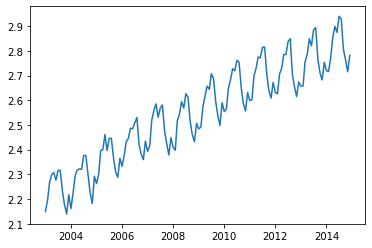

In [45]:
plt.plot(sales_ts_log)

In [46]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_ts_log)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -1.732472
p-value                          0.414464
#lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [47]:
sales_ts.head()

2003-01-01    141
2003-02-01    157
2003-03-01    185
2003-04-01    199
2003-05-01    203
Freq: MS, Name: Tractor-Sales, dtype: int64

In [48]:
sales_ts.diff(1).head()

2003-01-01     NaN
2003-02-01    16.0
2003-03-01    28.0
2003-04-01    14.0
2003-05-01     4.0
Freq: MS, Name: Tractor-Sales, dtype: float64

In [49]:
sales_ts_diff1 = sales_ts.diff(1)
sales_ts_diff1.dropna(inplace=True)

In [50]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_ts_diff1)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -2.543481
p-value                          0.105250
#lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [51]:
sales_ts_log_diff1 = sales_ts_log.diff(1)
sales_ts_log_diff1.dropna(inplace=True)

In [52]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_ts_log_diff1)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -2.680467
p-value                          0.077480
#lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [53]:
sales_ts_log_diff2 = sales_ts_log.diff(2)
sales_ts_log_diff2.dropna(inplace=True)

In [54]:
adfuller(sales_ts_log_diff2)

(-3.200721566232421,
 0.01994295010546021,
 11,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 -646.748135238141)

In [55]:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_ts_log_diff2)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -3.200722
p-value                          0.019943
#lags Used                      11.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


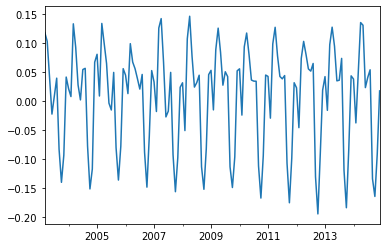

In [56]:
sales_ts_log_diff2.plot()

The following are some of our key observations from this analysis:
1) Trend: 12-months moving average looks quite similar to a straight line hence we could have easily used linear regression to estimate the trend in this data.
2) Seasonality: As discussed, seasonal plot displays a fairly consistent month-on-month pattern. The monthly seasonal components are average values for a month after removal of trend. Trend is removed from the time series using the following formula:

- Seasonalityt×Remaindert=YtTrendt

 
3) Irregular Remainder (random): is the residual left in the series after removal of trend and seasonal components. Remainder is calculated using the following formula:

- Remaindert=YtTrendt×Seasonalityt
 
The expectations from remainder component is that it should look like a white noise i.e. displays no pattern at all. However, for our series residual display some pattern with high variation on the edges of data i.e. near the beginning (2004-07) and the end (2013-14) of the series.

#### ARIMA Modeling
ARIMA is a combination of 3 parts i.e. AR (AutoRegressive), I (Integrated), and MA (Moving Average). A convenient notation for ARIMA model is ARIMA(p,d,q). Here p,d, and q are the levels for each of the AR, I, and MA parts. Each of these three parts is an effort to make the final residuals display a white noise pattern (or no pattern at all). In each step of ARIMA modeling, time series data is passed through these 3 parts like a sugar cane through a sugar cane juicer to produce juice-less residual. The sequence of three passes for ARIMA analysis is as following:

1st Pass of ARIMA to Extract Juice / Information
Integrated (I) – subtract time series with its lagged series to extract trends from the data
In this pass of ARIMA juicer, we extract trend(s) from the original time series data. Differencing is one of the most commonly used mechanisms for extraction of trends. Here, the original series is subtracted with it’s lagged series e.g. November’s sales values are subtracted with October’s values to produce trend-less residual series. The formulae for different orders of differencing are as follow:

- No Differencing (d=0) |  Y′t=YtYt′=Yt 
- 1st Differencing (d=1) |  Y′t=Yt−Yt−1Yt′=Yt−Yt−1 
- 2nd Differencing (d=1) |  Y′t=Yt−Yt−1−(Yt−1−Yt−2)=Yt−2×Yt−1+Yt−2Yt′=Yt−Yt−1−(Yt−1−Yt−2)=Yt−2×Yt−1+Yt−2 

For example, in the below plot a time series data with a linearly upward trend is displayed. Adjacent to that plot is the 1st order differenced plot for the same data. As we can notice after 1st order differencing, trend part of the series is extracted and the difference data (residual) does not display any trend.

#### Step 2: Difference data to make data stationary on mean (remove trend)
Clearly the tractor sales has an upward trend for tractors sales and there is also a seasonal component that we have already analyzed.

The next thing to do is to make the series stationary by removing the upward trend through 1st order differencing of the series using the following formula:

1st Differencing (d=1) |  Y′t=Yt−Yt−1

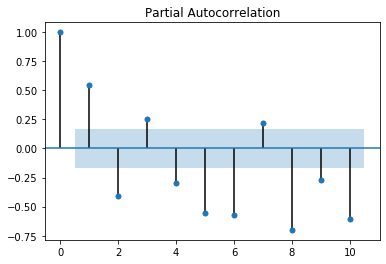

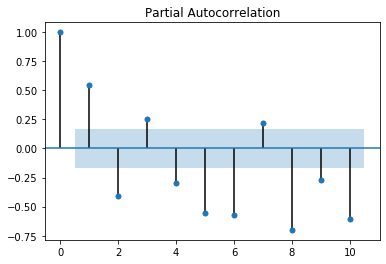

In [57]:
smt.graphics.plot_pacf(sales_ts_log_diff2, lags=10)

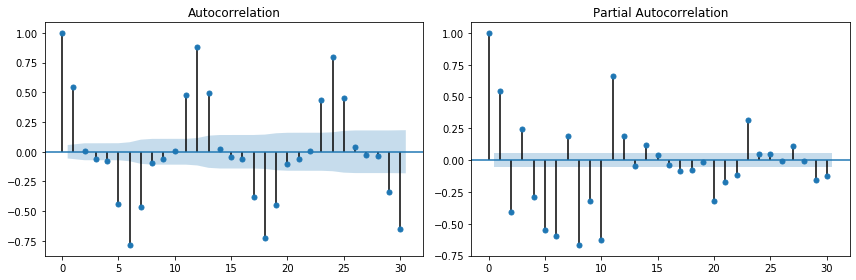

In [58]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(sales_ts_log_diff2, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(sales_ts_log_diff2, lags=30, ax=axes[1], alpha=0.5, method='ols')
plt.tight_layout()

Since, there are enough spikes in the plots outside the insignificant zone (dotted horizontal lines) we can conclude that the residuals are not random. This implies that there is juice or information available in residuals to be extracted by AR and MA models. Also, there is a seasonal component available in the residuals at the lag 12 (represented by spikes at lag 12). This makes sense since we are analyzing monthly data that tends to have seasonality of 12 months because of patterns in tractor sales.

#### Step 6: Identification of best fit ARIMA model

In order to fit the time series data with a seasonal ARIMA model, we need to first find the the values of ARIMA(p,d,q)(P,D,Q)s that optimize a metric of interest such as AIC or BIC. There are many guidelines and best practices to achieve this goal, yet the correct parametrization of ARIMA models can be a painstaking manual process that requires domain expertise and time. Auto arima function in forecast package in R helps us identify the best fit ARIMA model on the fly but in Python we will generate combination of p,d and q to select the optimal parameter values for our ARIMA(p,d,q)(P,D,Q)s time series model.
This technique is known as "grid search" where we iteratively explore different combinations of parameters. For each such combination of parameters, we try to fit a new seasonal ARIMA model with the SARIMAX() function from the statsmodels module and assess AIC or BIC score. The model with the best score wins and the parmeters for that model are the optimal parmeters.

In [59]:
model = sm.tsa.statespace.sarimax.SARIMAX(sales_ts_log_diff2, order = (1,2,1), 
                                             seasonal_order= (1,0,0,12),
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)

In [60]:
results = model.fit()

In [61]:
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                       Tractor-Sales   No. Observations:                  142
Model:             SARIMAX(1, 2, 1)x(1, 0, [], 12)   Log Likelihood                 279.836
Date:                             Sun, 20 Dec 2020   AIC                           -551.672
Time:                                     09:28:34   BIC                           -540.296
Sample:                                 03-01-2003   HQIC                          -547.050
                                      - 12-01-2014                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0739      0.078     -0.942      0.346      -0.228       0.080
ma.L1         -1.0000    19

In [62]:
np.power(10, results.forecast(steps=36))

2015-01-01    1.030792
2015-02-01    0.871726
2015-03-01    1.054035
2015-04-01    1.276476
2015-05-01    1.263076
2015-06-01    0.995784
2015-07-01    1.034756
2015-08-01    1.064958
2015-09-01    0.702976
2015-10-01    0.657091
2015-11-01    0.772249
2015-12-01    0.981429
2016-01-01    0.971582
2016-02-01    0.826897
2016-03-01    0.991927
2016-04-01    1.191693
2016-05-01    1.179280
2016-06-01    0.938283
2016-07-01    0.973177
2016-08-01    1.000090
2016-09-01    0.670984
2016-10-01    0.628669
2016-11-01    0.733840
2016-12-01    0.923405
2017-01-01    0.914197
2017-02-01    0.782823
2017-03-01    0.931932
2017-04-01    1.111053
2017-05-01    1.099565
2017-06-01    0.882592
2017-07-01    0.913768
2017-08-01    0.937694
2017-09-01    0.639024
2017-10-01    0.600082
2017-11-01    0.695914
2017-12-01    0.867377
Freq: MS, dtype: float64

### Iterate the process to find the best values for p, d, q and P, D, Q

In [63]:
# Define the p, d and q parameters to take any value between 0 and 2
p = q = range(0, 3)
d = range(2,3)
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

In [64]:
pdq

[(0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [65]:
# Generate all different combinations of seasonal p, q and q triplets
D = range(0,2)
P = Q = range(0, 2) 
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]

In [66]:
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [67]:
import sys
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(sales_ts_log,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
            results = temp_model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAXNonexNone12 model - AIC:inf


Best SARIMAX(1, 2, 1)x(1, 0, 1, 12)12 model - AIC:-673.2934415061015
The best fit model is selected based on Akaike Information Criterion (AIC) , and Bayesian Information Criterion (BIC) values. The idea is to choose a model with minimum AIC and BIC values.

#### Akaike Information Criterion (AIC) 
- AIC is an effort to balance the model between goodness-of-fit and number of parameters used in the model. This is similar to the balancing act between income and cost of a company so that the debs of the company is optimized (Debt = Cost - Income). As a modeler, we care about the maximum goodness of fit (income) with the minimum number of parameters (cost).

AIC=2K−2ln(L)AIC=2K−2ln(L) 

For the given model, L in the above formula is the maximized value of the likelihood function representing goodness-of-fit, and K the number of estimated parameters. Like our debts, we want to keep AIC value at the minimum to choose the best possible model. Bayesian Information Criterion (BIC) is another variant of AIC and is used for the same purpose of best fit model selection. For the best possible model selection, we want to look at AIC, BIC, and AICc (AIC with sample correction) if all these values are minimum for a given model. With increasing parameters K will increase and hence AIC increases. While with the goodness of the fit L increases thus decreasing AIC.

As expected, our model has I (or integrated) component equal to 1. This represents differencing of order 1. There is additional differencing of lag 12 in the above best fit model. Moreover, the best fit model has MA value of order 1. Also, there is seasonal MA with lag 12 of order 1.

The model that we got here is different from the one that was discussed in the blog. Let us validate that model with ours how does that perform with statsmodel as well as our model.

#### Step 7: Predict sales on in-sample date using the best fit ARIMA model
The next step is to predict tractor sales for in-sample data and find out how close is the model prediction on the in-sample data to the actual truth.

In [68]:
best_model = sm.tsa.statespace.SARIMAX(sales_ts_log,
                                      order=(1, 2, 1),
                                      seasonal_order=(1, 0, 1, 12),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
best_results = best_model.fit()

AttributeError: module 'statsmodels.tsa.statespace' has no attribute 'SARIMAX'

In [69]:
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])

NameError: name 'best_results' is not defined

In [ ]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2014-01-01'), full_results=True)

In [ ]:
pred_dynamic.predicted_mean

In [ ]:
np.power(10, pred_dynamic.predicted_mean)

In [ ]:
sales_ts['2014-01-01':]

In [ ]:
forecast = np.power(10,pred_dynamic.predicted_mean)

In [ ]:
actual = sales_ts['2014-01-01':]

In [ ]:
MAPE_last1year = np.mean(np.abs(actual - forecast)/actual)

In [ ]:
print('The Mean Absolute percentage error of our forecast for last two years is {}'.format(round(MAPE_last1year, 4)))


In [ ]:
# Compute the mean square error
mse = ((actual - forecast) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))
print('The ROOT Mean Squared Error of our forecasts is {}'.format(np.sqrt(round(mse, 4))))

In [ ]:
#Forecast for next 36 Months

In [ ]:
np.power(10, best_results.forecast(steps=36))

#### Step 8: Forecast sales using the best fit ARIMA model
The next step is to predict tractor sales for next 3 years i.e. for 2015, 2016, and 2017 through the above model.

In [ ]:
# Get forecast 36 steps (3 years) ahead in future
n_steps = 36
pred_uc_99 = best_results.get_forecast(steps=36, alpha=0.01) # alpha=0.01 signifies 99% confidence interval
pred_uc_95 = best_results.get_forecast(steps=36, alpha=0.05) # alpha=0.05 95% CI

# Get confidence intervals 95% & 99% of the forecasts
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()

In [ ]:
pred_ci_99.head()

In [ ]:
pred_ci_95.head()

In [ ]:
n_steps = 36
idx = pd.date_range(sales_ts.index[-1], periods=n_steps, freq='MS')
fc_95 = pd.DataFrame(np.column_stack([np.power(10, pred_uc_95.predicted_mean), np.power(10, pred_ci_95)]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([np.power(10, pred_ci_99)]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])

In [ ]:
fc_95.head()

In [ ]:
fc_99.head()

In [ ]:
fc_all = fc_95.combine_first(fc_99)
fc_all = fc_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']] # just reordering columns
fc_all.head()

In [ ]:
# plot the forecast along with the confidence band
axis = sales_ts.plot(label='Observed', figsize=(15, 6))
fc_all['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
#axis.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color='k', alpha=.25)
axis.fill_between(fc_all.index, fc_all['lower_ci_99'], fc_all['upper_ci_99'], color='k', alpha=.25)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')
plt.show()

In [ ]:
#Diagnostics
    #1. Errors follows normality
    #2. Errors should not have auto correlation (ACF, no spikes beyond the limits)
    #3. Errors should not have any spikes (if the spikes are present, that particular time period, model didn't predict propoerly)

In [ ]:
best_results.plot_diagnostics(lags=30, figsize=(16,12))
plt.show()

We need to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If it is not that it signifies that the model can be further improved and we repeat the process with the residuals.
In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:
- The KDE plot of the residuals on the top right is almost similar with the normal distribution.
- The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.
- The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

Those observations coupled with the fact that there are no spikes outside the insignificant zone for both ACF and PACF plots lead us to conclude that that residuals are random with no information or juice in them and our model produces a satisfactory fit that could help us understand our time series data and forecast future values. It sems that our ARIMA model is working fine.

# Timeseries Forecasting using FBProphet

Released by Facebook in 2017, forecasting tool Prophet is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, we are using Prophet to get a model up and running.

In [ ]:
from fbprophet import Prophet #you need to install fbprophet using pip install

In [ ]:
sales_data['ds'] = sales_data.index

In [ ]:
sales_data.head()

In [ ]:
sales_data = sales_data[['ds', 'Tractor-Sales']].rename(columns={'ds': 'ds', 'Tractor-Sales': 'y'})

In [ ]:
Prophet?

In [ ]:
sales_model = Prophet(interval_width=0.95)
sales_model.fit(sales_data)

In [ ]:
sales_forecast = sales_model.make_future_dataframe(periods=36, freq='MS')
sales_forecast = sales_model.predict(sales_forecast)

In [ ]:
sales_forecast

In [ ]:
plt.figure(figsize=(18, 6))
sales_model.plot(sales_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Tractor Sales');

#### Trends and Patterns
Now, we can use the Prophet Models to inspect different trends of these two categories in the data.

In [ ]:
sales_model.plot_components(sales_forecast);

Good to see that the tractor sales have been linearly increasing over time 

The worst months for tractor sales are November, December and January. The best months for tractor sales are july and august.

### Multivariate Time Series

####  Regression with ARIMA  (ARMAX/SARIMAX)
For the last 4 years, PowerHorse tractors is running an expensive marketing and farmer connect program to boost their sales. They are interested in learning the impact of this program on overall sales. As a data science consultant we are helping them with this effort. This is an interesting problem and requires a thorough analysis followed by creative solutions and scientific monitoring mechanism. To begin with we will build models based on regression with ARIMA errors and compare them with the pure play ARIMA model. This analysis will provide some clues towards effectiveness of the marketing program. However, this analysis will not be conclusive for finding shortcomings and enhancements for the program which will require further analysis and creative solutions.

In [ ]:
sm.tsa.SARIMAX?

In [ ]:
mkt_sales_data = pd.read_csv('sales-and-marketing.csv')

In [ ]:
mkt_sales_data.head()

In [ ]:
# since the complete date was not mentioned, we assume that it was the first of every month
mkt_sales_data.set_index(pd.date_range(start='2011-01-01', freq='MS', periods=len(mkt_sales_data)), inplace=True)
mkt_sales_data.drop(['Time Period'], axis=1, inplace=True)
mkt_sales_data.rename(columns={'Sales':'Tractor-Sales'}, inplace=True)
mkt_sales_data.head(5)

To begin with, we plot the following scatter plot of same months marketing expense and tractors sales.

In [ ]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(mkt_sales_data['Tractor-Sales'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

In [ ]:
mkt_sales_data_diff = mkt_sales_data.diff(periods=1)
mkt_sales_data_diff.dropna(inplace=True)

In [ ]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(mkt_sales_data_diff['Tractor-Sales'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

The correlation for the previous quarter also shows non-existent correlation with sales. Now, let’s build a regression model with ARIMA error (ARIMAX) model for the current and previous months.

In [ ]:
mkt_sales_data['Mkt_Exp_Lag_1'] = mkt_sales_data['Marketing Expense'].shift(1)
mkt_sales_data['Mkt_Exp_Lag_2'] = mkt_sales_data['Marketing Expense'].shift(2)
mkt_sales_data['Mkt_Exp_Lag_3'] = mkt_sales_data['Marketing Expense'].shift(3)
mkt_sales_data['Mkt_Exp_Lag_4'] = mkt_sales_data['Marketing Expense'].shift(4)

In [ ]:
mkt_sales_data.head()

In [ ]:
mkt_sales_data.corr()

In [ ]:
import sys

def auto_arima(timeseries, regressors=None, p=range(0, 2), d=range(0, 2), q=range(0, 2),
              P=range(0, 2), D=range(0, 1), Q=range(0, 2)):

    # Generate all different combinations of p, d and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]
    
    warnings.filterwarnings("ignore") # specify to ignore warning messages

    best_aic = np.inf
    best_pdq = None
    best_seasonal_pdq = None
    best_results = None
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:

            try:
                temp_model = sm.tsa.statespace.SARIMAX(endog=timeseries,
                                                 exog=regressors,
                                                 order = param,
                                                 seasonal_order = param_seasonal,
                                                 enforce_stationarity=False,
                                                 enforce_invertibility=False)
                temp_results = temp_model.fit()

                print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, temp_results.aic))
                
                if temp_results.aic < best_aic:
                    best_aic = temp_results.aic
                    best_pdq = param
                    best_seasonal_pdq = param_seasonal
                    best_results = temp_results
                
            except:
                #print("Unexpected error:", sys.exc_info()[0])
                continue
    print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))
    print(best_results.summary().tables[0])
    print(best_results.summary().tables[1])

In [ ]:
mkt_sales_data.dropna(inplace=True)
mkt_sales_data.head()

In [ ]:
mkt_sales_data.corr()

In [ ]:
#ARIMA Model with 2 months Lag Marekting Sales Data Regressor
timeseries = mkt_sales_data["Tractor-Sales"]
regressors = mkt_sales_data[["Marketing Expense", "Mkt_Exp_Lag_1", "Mkt_Exp_Lag_2"]]
best_results = auto_arima(timeseries, regressors, p=range(0, 2), d=range(0, 2), q=range(0, 2),
                         P=range(0, 2), D=range(0, 1), Q=range(0, 2))

In [ ]:
best_model = sm.tsa.statespace.SARIMAX(timeseries,
                                      exog = regressors,
                                      order=(1, 1, 0),
                                      seasonal_order=(1, 0, 0, 12),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
best_results = best_model.fit()

In [ ]:
print(best_results.summary())

In [ ]:
mkt_sales_data

In [ ]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2014-01-01'), full_results=True)

pred_dynamic.predicted_mean

In [ ]:
forecast = pred_dynamic.predicted_mean
actual = mkt_sales_data['2014-01-01':]['Tractor-Sales']

In [ ]:
actual

In [ ]:
MAPE_last1year = np.mean(np.abs(actual - forecast)/actual)

print('The Mean Absolute percentage error of our forecast for last two years is {}'.format(round(MAPE_last1year, 4)))

In [ ]:
# Compute the mean square error
mse = ((actual - forecast) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))
print('The ROOT Mean Squared Error of our forecasts is {}'.format(np.sqrt(round(mse, 4))))

In [ ]:
#Forecast future

In [ ]:
Future_mkt_spend = {
    '2015-01-01' : [600, 559.75, 527.60],
    '2015-02-01' : [550, 600, 559.75],
    '2015-03-01' : [700, 550, 600],
    '2015-04-01' : [590, 700, 550],
    '2015-05-01' : [480, 590, 700],
    '2015-06-01' : [520, 480, 590],
    '2015-07-01' : [800, 520, 480],
    '2015-08-01' : [675, 800, 520],
    '2015-09-01' : [820, 675, 800],
    '2015-10-01' : [710, 820, 675],
    '2015-11-01' : [550, 710, 820],
    '2015-12-01' : [590, 550, 710]
}

In [ ]:
Future_mkt_spend = pd.DataFrame(Future_mkt_spend).T

In [ ]:
Future_mkt_spend.columns = ['Marketing Expense', 'Mkt_Exp_Lag_1', 'Mkt_Exp_Lag_2']

In [ ]:
Future_mkt_spend

In [ ]:
#Forecast for next 12 Months
best_results.forecast(steps=12, exog=Future_mkt_spend)

In [ ]:
#### Step 8: Forecast sales using the best fit ARIMA model
#The next step is to predict tractor sales for next 6 Months through the above model.

# Get forecast 12 steps (12 Months) ahead in future
n_steps = 12
pred_uc_99 = best_results.get_forecast(steps=12, alpha=0.01, exog=Future_mkt_spend) # alpha=0.01 signifies 99% confidence interval
pred_uc_95 = best_results.get_forecast(steps=12, alpha=0.05, exog=Future_mkt_spend) # alpha=0.05 95% CI

# Get confidence intervals 95% & 99% of the forecasts
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()

In [ ]:
n_steps = 12
idx = pd.date_range(mkt_sales_data.index[-1], periods=n_steps, freq='MS')
fc_95 = pd.DataFrame(np.column_stack([pred_uc_95.predicted_mean, pred_ci_95]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])

fc_99 = pd.DataFrame(np.column_stack([pred_ci_99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all = fc_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']] # just reordering columns
fc_all.head()

In [ ]:
# plot the forecast along with the confidence band
axis = mkt_sales_data['Tractor-Sales'].plot(label='Observed', figsize=(15, 6))
fc_all['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
#axis.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color='k', alpha=.25)
axis.fill_between(fc_all.index, fc_all['lower_ci_99'], fc_all['upper_ci_99'], color='k', alpha=.25)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')
plt.show()

In [ ]:
#Diagnostics
    #1. Errors follows normality
    #2. Errors should not have auto correlation (ACF, no spikes beyond the limits)
    #3. Errors should not have any spikes (if the spikes are present, that particular time period, model didn't predict propoerly)


In [ ]:
best_results.plot_diagnostics(lags=24, figsize=(16,12))
plt.show()